# CIFAR-10: Transfer Learning con Modelos Pre-entrenados

En esta notebook, exploraremos el uso de **Transfer Learning** con modelos pre-entrenados para mejorar el rendimiento de modelos de clasificación en el dataset CIFAR-10. Veremos cómo utilizar arquitecturas avanzadas pre-entrenadas, adaptarlas al problema específico, y comparar su rendimiento con modelos entrenados desde cero.

## Introducción

### Objetivos

1. **Entender el concepto de Transfer Learning** y su aplicación en problemas de clasificación con conjuntos de datos pequeños o medianos como CIFAR-10.
2. **Utilizar arquitecturas avanzadas pre-entrenadas** (como ResNet, VGG, o DenseNet) en PyTorch y adaptarlas al dataset CIFAR-10.
3. **Comparar el rendimiento de los modelos pre-entrenados** con los modelos entrenados desde cero en el mismo conjunto de datos.
4. **Evaluar y analizar el impacto del Transfer Learning** en términos de tiempo de entrenamiento, precisión, y capacidad de generalización.

### Contenido

1. Configuración de bibliotecas y semillas para reproducibilidad.
2. Carga y exploración del dataset CIFAR-10.
3. Introducción al concepto de Transfer Learning y su implementación en PyTorch.
4. Utilización de modelos pre-entrenados:
    - Carga de modelos pre-entrenados (ResNet, VGG, DenseNet).
    - Adaptación de la última capa para clasificación en 10 clases.
    - Congelamiento y descongelamiento de capas según sea necesario.
5. Entrenamiento y evaluación de los modelos con Transfer Learning.
6. Comparación de resultados con modelos entrenados desde cero.
7. Análisis del rendimiento y conclusiones.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from torchvision.models import resnet18, ResNet18_Weights, densenet121, DenseNet121_Weights

from torchinfo import summary

import os
from pathlib import Path

from utils import (
    train,
    plot_taining,
    model_calassification_report,
)

In [2]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 23

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")


Device: cuda


In [ ]:

BATCH_SIZE = 256  # tamaño del batch

In [4]:
import platform

def get_workers():
    os_type = platform.system()
    if os_type == "Linux" or os_type == "Windows": # si estamos en Linux o Windows
        if os.cpu_count() < 4:
            return 0 # si tenemos menos de 4 cores, no usamos workers
        else:
            return os.cpu_count() - 1 # usamos todos los cores menos 1
    else: # si estamos en MacOS
        return 0 # no usamos workers

NUM_WORKERS = get_workers()
print(f"Num Workers: {NUM_WORKERS}")

Num Workers: 23


## Dataset y DataLoader

In [5]:
DATA_DIR = Path("data")

def get_dataloaders(
    train_transf, test_transf, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
):
    """
    Función para obtener los dataloaders de entrenamiento, validación y test

    Args:
    - train_transf: transformaciones para el dataset de entrenaiento
    - test_transf: transformaciones para el dataset de test
    - batch_size: tamaño del batch
    - num_workers: número de workers para cargar los datos
    """

    # descargamos el dataset CIFAR10 (si no lo tenemos ya)
    train_dataset = datasets.CIFAR10(
        DATA_DIR, train=True, download=True, transform=train_transf
    )
    test_dataset = datasets.CIFAR10(
        DATA_DIR, train=False, download=True, transform=test_transf
    )

    num_classes = len(train_dataset.classes)

    # dividimos el dataset de entrenamiento en entrenamiento y validación
    train_size = int(0.8 * len(train_dataset))
    valid_size = len(train_dataset) - train_size
    train_dataset, validation_dataset = random_split(
        train_dataset,
        [train_size, valid_size],
        generator=torch.Generator().manual_seed(SEED),  # fijamos la semilla
    )

    validation_dataset.transform = test_transf

    # creamos los dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    valid_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, valid_loader, test_loader, num_classes

Debemos tener en cuenta de transformar las imágenes cómo fue entrenado el modelo pre-entrenado.

https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights

In [6]:
T_MEAN = (0.485, 0.456, 0.406)
T_STD = (0.229, 0.224, 0.225)

# Transformaciones sin data augmentation
train_transforms_no_aug = T.Compose(
    [
        T.Resize((64, 64)),
        T.ToImage(),  # tenemos que convertir la imagen PIL a tensor
        T.ToDtype(torch.float32, scale=True),
        T.Normalize(mean=T_MEAN, std=T_STD),
    ]
)

In [7]:
train_loader, val_loader, test_loader, NUM_CLASES = get_dataloaders(train_transforms_no_aug, train_transforms_no_aug)

Files already downloaded and verified
Files already downloaded and verified


## Modelo Pre-entrenado

Para este ejemplo, utilizaremos el modelo **ResNet-18** pre-entrenado, disponible en PyTorch. ResNet es una arquitectura de red neuronal convolucional muy popular y ha demostrado un rendimiento excepcional en una variedad de tareas de visión por computadora. ResNet-18 es una versión más pequeña de la arquitectura original, que es más fácil de entrenar y más rápida de ejecutar.

PyTorch proporciona una interfaz sencilla para cargar modelos pre-entrenados y utilizarlos para tareas de clasificación. A continuación, cargaremos el modelo ResNet-18 pre-entrenado y lo adaptaremos para clasificar las 10 clases de CIFAR-10.

Para ver la lista completa de modelos pre-entrenados disponibles en PyTorch, puedes consultar la [documentación oficial](https://pytorch.org/vision/stable/models.html).

In [8]:
# Cargamos el modelo con los pesos preentrenados en ImageNet
weights = ResNet18_Weights.IMAGENET1K_V1
resnet_model = resnet18(weights=weights)

# cambiamos la última capa para que se ajuste a nuestro problema
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, NUM_CLASES)

summary(resnet_model, input_size=(BATCH_SIZE, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [256, 10]                 --
├─Conv2d: 1-1                            [256, 64, 16, 16]         9,408
├─BatchNorm2d: 1-2                       [256, 64, 16, 16]         128
├─ReLU: 1-3                              [256, 64, 16, 16]         --
├─MaxPool2d: 1-4                         [256, 64, 8, 8]           --
├─Sequential: 1-5                        [256, 64, 8, 8]           --
│    └─BasicBlock: 2-1                   [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-1                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-2             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-3                    [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-5             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-6                    [256, 64, 8, 8]           --
│

In [9]:
# definicion de hiperparametros
LR = 0.0005
EPOCHS = 10
# definimos
CRITERION = nn.CrossEntropyLoss().to(DEVICE)

Epoch: 001 | Train Loss: 0.54005 | Val Loss: 0.37535
Epoch: 002 | Train Loss: 0.22724 | Val Loss: 0.45209
Epoch: 003 | Train Loss: 0.13478 | Val Loss: 0.41036
Epoch: 004 | Train Loss: 0.09719 | Val Loss: 0.48996
Epoch: 005 | Train Loss: 0.07851 | Val Loss: 0.52244
Epoch: 006 | Train Loss: 0.06017 | Val Loss: 0.54075
Epoch: 007 | Train Loss: 0.04314 | Val Loss: 0.45877
Epoch: 008 | Train Loss: 0.04563 | Val Loss: 0.51355
Epoch: 009 | Train Loss: 0.05357 | Val Loss: 0.48447
Epoch: 010 | Train Loss: 0.04611 | Val Loss: 0.49443


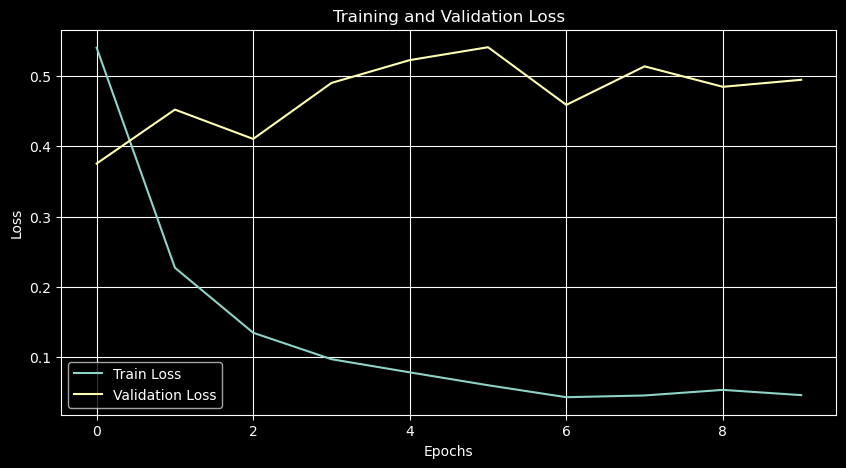

In [10]:
optimizer = optim.Adam(resnet_model.parameters(), lr=LR)

train_errors, val_errors = train(
    model=resnet_model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=False,
    epochs=EPOCHS,
)

plot_taining(train_errors, val_errors)

In [11]:
model_calassification_report(resnet_model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.8722

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88      1000
           1       0.93      0.93      0.93      1000
           2       0.88      0.80      0.84      1000
           3       0.71      0.82      0.76      1000
           4       0.88      0.85      0.87      1000
           5       0.85      0.76      0.80      1000
           6       0.90      0.92      0.91      1000
           7       0.93      0.89      0.91      1000
           8       0.84      0.96      0.90      1000
           9       0.94      0.90      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



In [12]:
# Cargamos el modelo con los pesos preentrenados en ImageNet
weights = DenseNet121_Weights.IMAGENET1K_V1
densenet_model = densenet121(weights=weights)

# cambiamos la última capa para que se ajuste a nuestro problema
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, NUM_CLASES)

# congelamos los pesos de las capas convolucionales
for param in densenet_model.parameters():
    param.requires_grad = False

# des-congelamos los pesos de la última capa
for param in densenet_model.classifier.parameters():
    param.requires_grad = True

summary(densenet_model, input_size=(BATCH_SIZE, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [256, 10]                 --
├─Sequential: 1-1                        [256, 1024, 1, 1]         --
│    └─Conv2d: 2-1                       [256, 64, 16, 16]         (9,408)
│    └─BatchNorm2d: 2-2                  [256, 64, 16, 16]         (128)
│    └─ReLU: 2-3                         [256, 64, 16, 16]         --
│    └─MaxPool2d: 2-4                    [256, 64, 8, 8]           --
│    └─_DenseBlock: 2-5                  [256, 256, 8, 8]          --
│    │    └─_DenseLayer: 3-1             [256, 32, 8, 8]           (45,440)
│    │    └─_DenseLayer: 3-2             [256, 32, 8, 8]           (49,600)
│    │    └─_DenseLayer: 3-3             [256, 32, 8, 8]           (53,760)
│    │    └─_DenseLayer: 3-4             [256, 32, 8, 8]           (57,920)
│    │    └─_DenseLayer: 3-5             [256, 32, 8, 8]           (62,080)
│    │    └─_DenseLayer: 3-6             [256, 

Epoch: 001 | Train Loss: 1.47532 | Val Loss: 1.12221
Epoch: 002 | Train Loss: 1.04267 | Val Loss: 0.98153
Epoch: 003 | Train Loss: 0.94863 | Val Loss: 0.92814
Epoch: 004 | Train Loss: 0.90120 | Val Loss: 0.89940
Epoch: 005 | Train Loss: 0.87332 | Val Loss: 0.88788
Epoch: 006 | Train Loss: 0.85028 | Val Loss: 0.87270
Epoch: 007 | Train Loss: 0.83659 | Val Loss: 0.87186
Epoch: 008 | Train Loss: 0.82588 | Val Loss: 0.85520
Epoch: 009 | Train Loss: 0.81654 | Val Loss: 0.86143
Epoch: 010 | Train Loss: 0.80817 | Val Loss: 0.85525


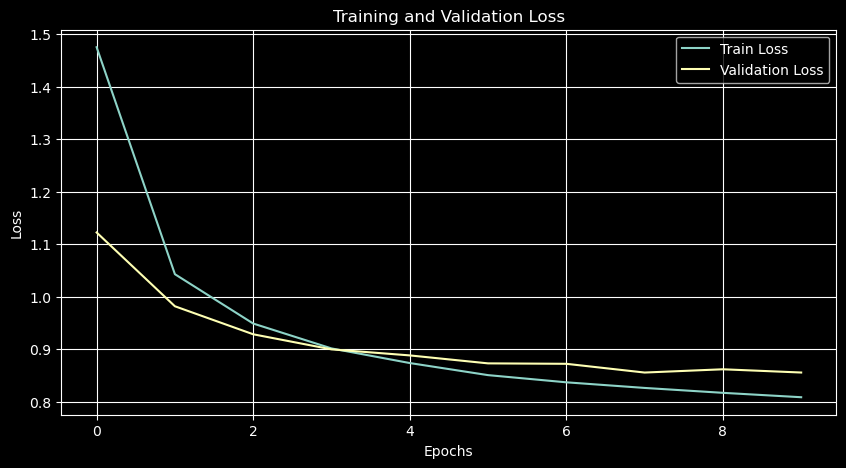

In [13]:
optimizer = optim.Adam(densenet_model.parameters(), lr=LR)

train_errors, val_errors = train(
    model=densenet_model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=False,
    epochs=EPOCHS,
)

plot_taining(train_errors, val_errors)

In [14]:
model_calassification_report(densenet_model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.7028

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.73      0.80      0.76      1000
           1       0.82      0.79      0.81      1000
           2       0.67      0.57      0.62      1000
           3       0.54      0.60      0.57      1000
           4       0.62      0.63      0.62      1000
           5       0.72      0.58      0.64      1000
           6       0.69      0.77      0.73      1000
           7       0.70      0.74      0.72      1000
           8       0.78      0.78      0.78      1000
           9       0.78      0.77      0.77      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000

